In [1]:
# Import libraries
import numpy as np
from glob import glob
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask

import geopandas as gpd
from shapely.geometry import mapping, box
from shapely.geometry import Point, Polygon

import earthpy as et
import earthpy.spatial as es
import earthpy.clip as cl

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Open avalanche paths
avalanche_paths_filename = glob(os.path.join(
    'data', 'final-project', 'cottonwood-heights-utah', 'avalanche-paths', '*.shp'))
avalanche_paths = gpd.read_file(avalanche_paths_filename[0])

In [3]:
avalanche_paths.crs

{'init': 'epsg:26912'}

In [4]:
# Plot some points on the map to check location
bottom_left = np.array([[436438, 4484000]])
geometry_bl = [Point(xy) for xy in bottom_left]
bottom_left_loc = gpd.GeoDataFrame(geometry_bl,
                                   columns=['geometry'],
                                   crs={'init': 'epsg:26912'})

bottom_right = np.array([[452700, 4492000]])
geometry_br = [Point(xy) for xy in bottom_right]
bottom_right_loc = gpd.GeoDataFrame(geometry_br,
                                    columns=['geometry'],
                                    crs={'init': 'epsg:26912'})

top_right = np.array([[452700, 4496000]])
geometry_tr = [Point(xy) for xy in top_right]
top_right_loc = gpd.GeoDataFrame(geometry_tr,
                                 columns=['geometry'],
                                 crs={'init': 'epsg:26912'})

top_left = np.array([[436438, 4493600]])
geometry_tl = [Point(xy) for xy in top_left]
top_left_loc = gpd.GeoDataFrame(geometry_tl,
                                columns=['geometry'],
                                crs={'init': 'epsg:26912'})

# Put all points in a numpy array for plotting a line between points
x_points = [bottom_left[0, 0], bottom_right[0, 0],
            top_right[0, 0], top_left[0, 0], bottom_left[0, 0]]
y_points = [bottom_left[0, 1], bottom_right[0, 1],
            top_right[0, 1], top_left[0, 1], bottom_left[0, 1]]

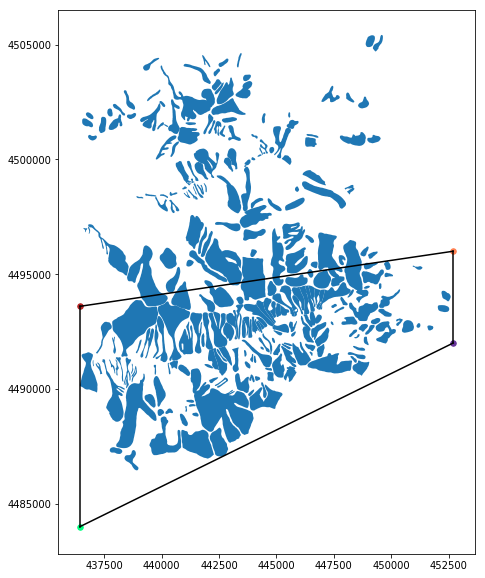

In [5]:
# Plot avalanche paths
fig, ax1 = plt.subplots(figsize=(10, 10))
avalanche_paths.plot(ax=ax1)

# Plot points on map
bottom_left_loc.plot(ax=ax1,
                     markersize=30,
                     color='springgreen')

bottom_right_loc.plot(ax=ax1,
                      markersize=30,
                      color='rebeccapurple')

top_right_loc.plot(ax=ax1,
                   markersize=30,
                   color='coral')

top_left_loc.plot(ax=ax1,
                  markersize=30,
                  color='firebrick')

# Connect the lines
plt.plot([x_points[0], x_points[1]], [y_points[0], y_points[1]], 'k-')
plt.plot([x_points[1], x_points[2]], [y_points[1], y_points[2]], 'k-')
plt.plot([x_points[2], x_points[3]], [y_points[2], y_points[3]], 'k-')
plt.plot([x_points[3], x_points[4]], [y_points[3], y_points[4]], 'k-')

# turn off axis
# plt.gca().axes.get_yaxis().set_visible(False)
# plt.gca().axes.get_xaxis().set_visible(False)

In [6]:
# Look at avalanche path spatial attributes
print(avalanche_paths.total_bounds)
print(avalanche_paths.crs)

[ 436438.  4486454.   452594.5 4505425. ]
{'init': 'epsg:26912'}


Corner points of full shapefile
* bottom left: (436438.0, 4486454.0) / 40.5263854°, -111.7504277°
* bottom right: (436438.0, 4505425.0) / 40.5263854°, -111.5611183°
* top right: (452594.5, 4505425.0) / 40.6983653°, -111.5611183°
* top left: (452594.5, 4486454.0) / 40.6983653°, -111.7504277°
* center: 40.6155°, -111.6606°

Corner points of cropped area
* bl: (436438, 4484000) / 40.5042792°, -111.7501813°
* br: (452700, 4492000) / 40.5774339°, -111.5588601°
* tr: (452700, 4496000) / 40.6134677°, -111.5591603°
* tl: (436438, 4494000) / 40.5943609°, -111.7511872°
* center: 40.5725°, -111.6578°

## Create Clipping Boundary Shapefile

In [3]:
# Create dataframe that holds the clipping box
poly_inters = Polygon([(436438, 4484000), (452700, 4492000),
                       (452700, 4496000), (436438, 4493600), (436438, 4484000)])
poly_in_gdf = gpd.GeoDataFrame([1],
                               geometry=[poly_inters],
                               crs={'init': 'epsg:26912'})

# Rename the columns to work with to_file()
poly_in_gdf.rename(columns={0: 'poly_no'}, inplace=True)

# Save to shapefile
clip_out_path = os.path.join('final-project', 'avalanche-mapping', 'data', 'vector', 'site-boundary', 'site-boundary.shp')
if os.path.exists(clip_out_path) == False:
    poly_in_gdf.to_file(clip_out_path, driver='ESRI Shapefile')

In [8]:
# Open boundary shapefile to make sure it works
avalanche_boundary = gpd.read_file(clip_out_path)
avalanche_boundary.crs

{'init': 'epsg:26912'}

## Plot Avalanche Paths with Boundary on Top

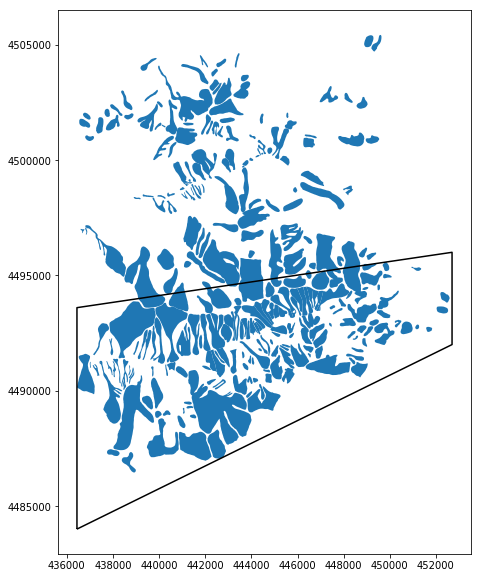

In [9]:
# Plot avalanche paths
fig, ax1 = plt.subplots(figsize=(10, 10))
avalanche_paths.plot(ax=ax1)
avalanche_boundary.boundary.plot(ax=ax1, color="black")

## Clip the Avalanche Data to the Boundary

In [10]:
# Clip data to boundary
avalanche_clip = cl.clip_shp(avalanche_paths, poly_in_gdf)

# Create Alta ski resort point
alta = np.array([[446074.76, 4493257.42]])
geometry = [Point(xy) for xy in alta]
alta_loc = gpd.GeoDataFrame(geometry,
                            columns=['geometry'],
                            crs={'init': 'epsg:26912'})

In [18]:
poly_in_gdf

,poly_no,geometry
0,1,"POLYGON ((436438 4484000, 452700 4492000, 4527..."


In [11]:
alta_loc[["geometry"]]

,geometry
0,POINT (446074.76 4493257.42)


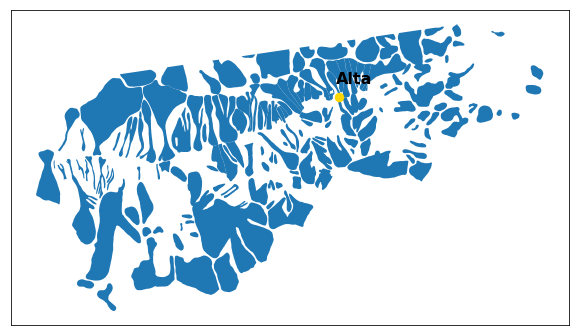

In [12]:
# Plot clipped avalanche paths
fig, ax1 = plt.subplots(figsize=(10, 10))
avalanche_clip.plot(ax=ax1)
alta_loc.plot(ax=ax1,
              markersize=72,
              color='gold')
ax1.annotate('Alta', xy=(446074.76, 4493257.42), xytext=(446000, 4493700), fontsize=16, fontweight='bold')
# turn off axis
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

## Create Location Map for Midterm Presentation

In [2]:
# Import world boundary shapefile and state boundary shape file
worldBound = gpd.read_file(
    "data/spatial-vector-lidar/global/ne_110m_land/ne_110m_land.shp")
state_boundary_us = gpd.read_file(
    'data/spatial-vector-lidar/usa/usa-states-census-2014.shp')
cottonwood_heights_utah = np.array([[-111.6578, 40.5725]])
geometry = [Point(xy) for xy in cottonwood_heights_utah]
utah_loc = gpd.GeoDataFrame(geometry,
                            columns=['geometry'],
                            crs={'init': 'epsg:4326'})

In [3]:
state_boundary_us.crs

{'init': 'epsg:4326'}

In [5]:
worldBound = gpd.read_file(os.path.join(
    'data', 'spatial-vector-lidar', 'global', 'ne_110m_land', 'ne_110m_land.shp'))

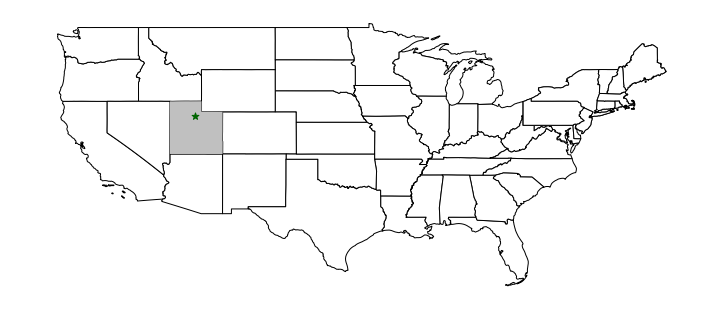

In [15]:
# plot state boundary
fig, ax = plt.subplots(figsize=(12, 8))
state_boundary_us.plot(ax=ax, facecolor='white', edgecolor='black')
utah_boundary = state_boundary_us[state_boundary_us.STUSPS == 'UT']
utah_boundary.plot(ax=ax,
                  color='silver')
utah_loc.plot(ax=ax,
              markersize=52,
              marker='*',
              color='darkgreen')


# turn off axis
ax.set_axis_off()

In [ ]:
worldBound.crs

In [ ]:
utah_boundary.crs